In [1]:
import sys
sys.path.append('../src')

In [2]:
import common.config as cfg
from common.nb_utils import estimate_optimal_ncomponents, pca_transform
from common.utils import get_device, Struct
from data.loader import get_testloader, get_trainloader
import matplotlib.pyplot as plt
from models.fcn import FCN
from models.resnet import resnet18
from models.model_op import get_model_grads, gradient_approximation
from models.svm import SVM
import models.resnet as resnet
import numpy as np
import pickle as pkl
import torch as t
import time
from tqdm.notebook import tqdm

In [3]:
dataset = 'mnist'
input_size = cfg.input_sizes[dataset]
output_size = cfg.output_sizes[dataset]
lr = 1e-1
sdirs_algo = 'pca' # 'qr'
bs = 16
epochs = 20

In [4]:
device = t.device('cuda:1')
loss = t.nn.CrossEntropyLoss().to(device)

In [5]:
trainloader = get_trainloader(dataset, bs, True)
testloader = get_testloader(dataset, bs, True)

In [6]:
sdirs = []
m = 6
n_accum = m*50
for idx, (data, labels) in tqdm(enumerate(trainloader), total=len(trainloader), leave=False):
    x, y = data.to(device), labels.to(device)
    model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
    optimizer = t.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()
    y_hat = model(x)
    loss_val = loss(y_hat, y)
    loss_val.backward()
    sdirs.append(get_model_grads(model))
    if idx == n_accum:
        break

In [ ]:
sdirs_ = []
for i in range(len(sdirs[0])):
    sdirs_.append(np.hstack([_[i].reshape(-1, 1).cpu().numpy() for _ in sdirs]))
[_.shape for _ in sdirs_]
n0 = [_.shape[1] for _ in sdirs_]

In [ ]:
n = [estimate_optimal_ncomponents(_, 0.99)[0] for _ in sdirs_]

In [ ]:
plt.figure(figsize=(10, 2))
plt.bar(range(len(n0)), [_/m for _ in n0], color='r')
plt.bar(range(len(n)), [_/m for _ in n], color='k', alpha=0.6)
plt.title('grads: {}, bs: {}, dataset: {}'.format(n_accum, bs, dataset))
name = '../ckpts/nb/grads_{}_bs_{}_dataset_{}.png'.format(
    n_accum, bs, dataset
)
print(name)
plt.savefig(name, bbox_inches='tight', dpi=330)

# BS: 32 MNIST
![](../ckpts/nb/grads_300_bs_16_dataset_mnist.png)
![](../ckpts/nb/grads_200_bs_16_dataset_mnist.png)
![](../ckpts/nb/grads_100_bs_16_dataset_mnist.png)
![](../ckpts/nb/grads_50_bs_16_dataset_mnist.png)

# BS: 128 MNIST
![](../ckpts/nb/grads_300_bs_128_dataset_mnist.png)
![](../ckpts/nb/grads_200_bs_128_dataset_mnist.png)
![](../ckpts/nb/grads_100_bs_128_dataset_mnist.png)
![](../ckpts/nb/grads_50_bs_128_dataset_mnist.png)

In [ ]:
if sdirs_algo=='pca':
    sdirs0, _ = pca_transform(sdirs0, n0)
#     sdirs1, _ = pca_transform(sdirs1, n1)
else:
    sdirs0, _ = np.linalg.qr(sdirs0)
#     sdirs1, _ = np.linalg.qr(sdirs1)
sdirs0.shape, sdirs1.shape

In [ ]:
sdirs = [[t.Tensor(sdirs0[:, _].reshape(output_size, input_size)), t.Tensor(sdirs1[:,_].reshape(output_size,))] for _ in range(sdirs0.shape[1])]

# pretraining

In [7]:
trainloader = get_trainloader(dataset, 256, False)
testloader = get_testloader(dataset, 256, False)

In [8]:
model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

correcti = 0
x_test = 0
for idx, (data, labels) in enumerate(testloader):
    x, y = data.to(device), labels.to(device)
    y_hat = model(x)
    loss_val = loss(y_hat, y)
    predi = y_hat.argmax(1, keepdim=True)
    correcti += predi.eq(y.view_as(predi)).sum().item()
y_test = correcti/len(testloader.dataset)
x_test, y_test

(0, 0.1046)

# w/o gradient approximation

In [9]:
model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xb_train, yb_train = [], []
xb_test, yb_test =[], []
for _ in tqdm(range(1, epochs+1), leave=False):
    xb_train.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yb_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yb_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xb_train[-1], loss_val.item(), yb_train[-1], yb_test[-1]
    ))

1 	 0.0002 	 0.95 	 0.98
2 	 0.0002 	 0.99 	 0.99
3 	 0.0001 	 1.00 	 0.99
4 	 0.0000 	 1.00 	 0.99
5 	 0.0000 	 1.00 	 0.99
6 	 0.0000 	 1.00 	 0.99
7 	 0.0000 	 1.00 	 0.99
8 	 0.0000 	 1.00 	 0.99
9 	 0.0000 	 1.00 	 0.99
10 	 0.0000 	 1.00 	 0.99
11 	 0.0000 	 1.00 	 0.99
12 	 0.0000 	 1.00 	 0.99
13 	 0.0000 	 1.00 	 0.99
14 	 0.0000 	 1.00 	 0.99
15 	 0.0000 	 1.00 	 0.99
16 	 0.0000 	 1.00 	 0.99
17 	 0.0000 	 1.00 	 0.99
18 	 0.0000 	 1.00 	 0.99
19 	 0.0000 	 1.00 	 0.99
20 	 0.0000 	 1.00 	 0.99


# gradient approximation using all directions

In [ ]:
model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xa_train, ya_train = [], []
xa_test, ya_test = [], []
for _ in tqdm(range(1, epochs+1), leave=False):
    start = time.time()
    xa_train.append(_)
    xa_test.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        _, error = gradient_approximation(model, sdirs, device, [])
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    ya_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    ya_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xa_train[-1], loss_val.item(), ya_train[-1], ya_test[-1]
    ))

# gradient approximation using n directions

In [10]:
n = 1
model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xe_train, ye_train = [], []
xe_test, ye_test = [], []
for _ in tqdm(range(1, epochs+1), leave=False):
    start = time.time()
    xe_train.append(_)
    xe_test.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        _, error = gradient_approximation(
            model, 
            [sdirs[idx]], device, [])
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    ye_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    ye_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xe_train[-1], loss_val.item(), ye_train[-1], ye_test[-1]
    ))

1 	 2.5131 	 0.13 	 0.13
2 	 2.3030 	 0.16 	 0.15
3 	 2.2889 	 0.19 	 0.19
4 	 2.0671 	 0.23 	 0.23
5 	 1.8783 	 0.26 	 0.26
6 	 1.5959 	 0.29 	 0.32
7 	 1.6604 	 0.33 	 0.33
8 	 1.3168 	 0.35 	 0.36
9 	 1.6746 	 0.36 	 0.37
10 	 1.7229 	 0.39 	 0.40
11 	 1.7209 	 0.41 	 0.42
12 	 1.3538 	 0.42 	 0.45
13 	 1.4626 	 0.44 	 0.45
14 	 0.8445 	 0.46 	 0.48
15 	 1.3905 	 0.47 	 0.49
16 	 1.1864 	 0.50 	 0.52
17 	 0.7132 	 0.52 	 0.53
18 	 1.1436 	 0.52 	 0.52
19 	 1.0870 	 0.54 	 0.54
20 	 1.5908 	 0.54 	 0.55


In [11]:
n = 10
model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xc_train, yc_train = [], []
xc_test, yc_test = [], []
for _ in tqdm(range(1, epochs+1), leave=False):
    start = time.time()
    xc_train.append(_)
    xc_test.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        _, error = gradient_approximation(
            model, 
            sdirs[idx: idx+n] , device, [])
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yc_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yc_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xc_train[-1], loss_val.item(), yc_train[-1], yc_test[-1]
    ))

1 	 2.2950 	 0.17 	 0.32
2 	 1.9856 	 0.33 	 0.33
3 	 1.5854 	 0.51 	 0.43
4 	 0.4543 	 0.64 	 0.70
5 	 0.5155 	 0.71 	 0.76
6 	 0.7209 	 0.76 	 0.76
7 	 0.4639 	 0.78 	 0.77
8 	 0.7979 	 0.80 	 0.81
9 	 0.6760 	 0.81 	 0.82
10 	 0.4692 	 0.82 	 0.83
11 	 0.4171 	 0.84 	 0.84
12 	 0.4464 	 0.84 	 0.84
13 	 0.2587 	 0.85 	 0.85
14 	 0.4854 	 0.86 	 0.86
15 	 0.3056 	 0.86 	 0.86
16 	 0.2146 	 0.86 	 0.86
17 	 0.2547 	 0.87 	 0.85
18 	 0.1713 	 0.87 	 0.87
19 	 0.1330 	 0.87 	 0.87
20 	 0.1434 	 0.87 	 0.88


In [12]:
n = 100
model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xd_train, yd_train = [], []
xd_test, yd_test = [], []
for _ in tqdm(range(1, epochs+1), leave=False):
    start = time.time()
    xd_train.append(_)
    xd_test.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        _, error = gradient_approximation(
            model, 
            sdirs[idx: idx+n], device, [])
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yd_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yd_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xd_train[-1], loss_val.item(), yd_train[-1], yd_test[-1]
    ))

1 	 1.4333 	 0.23 	 0.52
2 	 0.6550 	 0.55 	 0.76
3 	 0.2416 	 0.75 	 0.86
4 	 0.1677 	 0.85 	 0.89
5 	 0.0789 	 0.90 	 0.91
6 	 0.0632 	 0.92 	 0.92
7 	 0.0313 	 0.93 	 0.93
8 	 0.0240 	 0.94 	 0.94
9 	 0.0192 	 0.94 	 0.95
10 	 0.0146 	 0.95 	 0.95
11 	 0.0186 	 0.95 	 0.95
12 	 0.0147 	 0.95 	 0.95
13 	 0.0145 	 0.96 	 0.95
14 	 0.0127 	 0.96 	 0.96
15 	 0.0145 	 0.96 	 0.96
16 	 0.0104 	 0.96 	 0.96
17 	 0.0092 	 0.96 	 0.96
18 	 0.0113 	 0.97 	 0.96
19 	 0.0147 	 0.97 	 0.96
20 	 0.0118 	 0.97 	 0.96


clf_resnet18_mnist_algo_pca_bs_16_sgd_vs_sgd_approx_random_grad_sampling


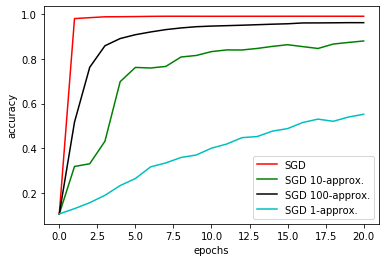

In [13]:
plt.figure()
plt.plot([x_test]+xb_train, [y_test]+yb_test, label='SGD', c='r')
# plt.plot([x_test]+xa_train, [y_test]+ya_test, label='SGD {}-approx.'.format(len(sdirs)), c='b')
plt.plot([x_test]+xc_train, [y_test]+yc_test, label='SGD 10-approx.', c='g')
plt.plot([x_test]+xd_train, [y_test]+yd_test, label='SGD 100-approx.', c='k')
plt.plot([x_test]+xe_train, [y_test]+ye_test, label='SGD 1-approx.', c='c')

history = {
    'test': [x_test, y_test],
#     'a': [xa_train, ya_train, xa_test, ya_test],
    'b': [xb_train, yb_train, xb_test, yb_test],
    'c': [xc_train, yc_train, xc_test, yc_test],
    'd': [xd_train, yd_train, xd_test, yd_test],
    'e': [xe_train, ye_train, xe_test, ye_test],
}

name = 'clf_{}_{}_algo_{}_bs_{}_sgd_vs_sgd_approx_random_grad_sampling'.format(
    'resnet18', dataset, sdirs_algo, bs)
print(name)

pkl.dump(history, open('../ckpts/history/{}.pkl'.format(name), 'wb'))

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig(
    '../ckpts/plots/{}.png'.format(name), 
    dpi=300, bbox_inches='tight'
)